In [2]:
# imports
import h5py
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from datetime import datetime
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# hdf file import
# These files contain 45 (25-70 are missing) 3D images of size 256 x 256 x 256. The images are stacked along the first dimesion. 
# each pixel has a itensity between 0 and 1

print('loading hdf files')
file1 = h5py.File('input_images/data_T1_2d_size_256_256_depth_256_res_0.7_0.7_from_0_to_20.hdf5', 'r')
file2 = h5py.File('input_images/data_T1_2d_size_256_256_depth_256_res_0.7_0.7_from_20_to_25.hdf5', 'r')
file3 = h5py.File('input_images/data_T1_2d_size_256_256_depth_256_res_0.7_0.7_from_50_to_70.hdf5', 'r')

file1.keys()

loading hdf files


<KeysViewHDF5 ['images', 'labels', 'nx', 'ny', 'nz', 'patnames', 'px', 'py', 'pz']>

In [4]:
print('create numpy object')
set1 = np.array(file1['images'])
set2 = np.array(file2['images'])
set3 = np.array(file3['images'])

brain_set = np.vstack((set1, set2, set3))

brain_set = brain_set.reshape(-1,256,256,256)
brain_set.shape

create numpy object


/tmp/ipykernel_22764/1362396705.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  set1 = np.array(file1['images'])
/tmp/ipykernel_22764/1362396705.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  set2 = np.array(file2['images'])
/tmp/ipykernel_22764/1362396705.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  set3 = np.array(file3['images'])


(45, 256, 256, 256)

  ![Alt text](http://www.grahamwideman.com/gw/brain/orientation/talairachdaemon.gif)

In [5]:
#example image
# [scan nr, y, x, z-coordinates ]
image = brain_set[44,:,:,:]

# i tried to visualize the data with pyvista. but came into alot of unresolvable dependecies.
# Therfor only slice wise

plt.imshow(image[30])
plt.show()
#plt.savefig('slice.png')

In [6]:
#Dataloader
# We load the image in singele pixels as one long 1D array.
# one pixel entry is a arry with [intesity, cooridinate 1, coordinate 2]

class medical_3D_set(Dataset):
    def __init__(self,data):
        self.data = data
        print('dataset on GPU? (CPU = -1):',self.data.get_device())

    def __len__(self):
        return self.data.shape[0]                                               # number of pixels loaded
    
    def __getitem__(self, idx):
        intensity = self.data[idx][0:1]      #intesitiy at coordinate
        coordinate =  self.data[idx][1:4]   #array x,y,z coordinate
        
        return intensity, coordinate

In [7]:
# converting slice/image in to array of intensity coordinate pair
# and return it as dataloader class
def make_3D_dataset(image): 

    # create 0 to 1 coordinate mesh
    nx,ny, nz = image.shape
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    z = np.linspace(0, 1, nz)
    xv, yv, zv= np.meshgrid(x, y, z)

    #make intensity coordinate pairs
    image_flat = image.flatten()
    xf = xv.flatten()
    yf = yv.flatten()
    zf = zv.flatten()
    pixels = np.vstack((image_flat, xf,yf,zf)).T
    
    pixels = torch.tensor(pixels , dtype= torch.float32)
    pixels = pixels.to(device)

    #print('size singel slice pixel array:', pixels.shape)

    return medical_3D_set(pixels)    # initiate data loader

In [8]:
# MLP as mentioned in Learning Continuous Image Representation with Local Implicit Image Function from Yinbo Chen

class Net_3D(nn.Module):
    def __init__(self):
      super(Net_3D, self).__init__()
      NODES = 1024
      self.fc1 = nn.Linear(3, NODES)
      self.fc2 = nn.Linear(NODES, NODES)
      self.fc3 = nn.Linear(NODES, NODES)
      self.fc4 = nn.Linear(NODES, NODES)
      self.fc5 = nn.Linear(NODES, 1)

    def forward(self, x):
       x = self.fc1(x)
       x = F.relu(x)
       x = self.fc2(x)
       x = F.relu(x)
       x = self.fc3(x)
       x = F.relu(x)
       x = self.fc4(x)
       x = F.relu(x)
       x = self.fc5(x)
       #x = F.sigmoid(x)   # ensure 0 1 output
       return x

In [14]:
# Define Parameters

BATCH_SIZE = 48
EPOCHS = 300

MODEL_OUTPUT_PATH = 'output_model_3D/'
MODEL_INTERMEDIAT_PATH = 'output_intermediate_model_3D/'

LEARING_RATE = 5e-4

In [10]:
# Class with all functions for trainig of one slice/image


class trainig():
    def __init__(self, dataset,image_name):
        # creating MLP
        self.threeD_nn = Net_3D()
        self.threeD_nn = self.threeD_nn.to(device)


        # initiate Dataloader
        self.training_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        

        # Optimizer and loss
        # as mentioned in Learning Continuous Image Representation with Local Implicit Image Function from Yinbo Chen
        self.optimizer = torch.optim.Adam(self.threeD_nn.parameters(), lr=LEARING_RATE)
        self.loss_fn = torch.nn.L1Loss()

        #keep track of best model
        self.best_loss_path = ''
        self.image_name = image_name



    # Main trainig loop
    def train_loop(self):

        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        epoch_number = 0
        best_loss = 1_000_000
        


        for epoch in range(EPOCHS):
            print('EPOCH {}:'.format(epoch_number + 1))

            # Make sure gradient tracking is on, and do a pass over the data
            self.threeD_nn.train(True)
            avg_loss = self.train_one_epoch(epoch_number)

            print('LOSS train {}'.format(avg_loss))


            # Track best performance, and save the model's state
            if avg_loss < best_loss:
                best_loss = avg_loss
                model_path = MODEL_INTERMEDIAT_PATH +'{}_{}_E{}_L{}'.format(timestamp, self.image_name, epoch_number, np.round(avg_loss,5))
                self.best_loss_path = model_path
                torch.save(self.threeD_nn.state_dict(), model_path)

            epoch_number += 1



    def train_one_epoch(self,epoch_index):
        running_loss = 0.
        last_loss = 0.
        running_load =0.
        running_calc = 0.


        for i, data in enumerate(self.training_loader):
            # Every data instance is an input + label pair
            labels, inputs = data
            #print('labels on GPU? (CPU = -1):', labels.get_device())
            

            # Zero your gradients for every batch!
            self.optimizer.zero_grad()

            # Make predictions for this batch
            outputs = self.threeD_nn(inputs)

            # Compute the loss and its gradients
            loss = self.loss_fn(outputs, labels)
            loss.backward()

            # Adjust learning weights
            self.optimizer.step()

            # Gather data and report
            running_loss += loss.item()
            if i % 1000 == 999:
                last_loss = running_loss / 1000 # loss per batch
                print('  batch {} loss: {}'.format(i + 1, last_loss))
                running_loss = 0.

        return last_loss
    
    def save_best(self):
        self.threeD_nn.load_state_dict(torch.load(self.best_loss_path))

        model_path = MODEL_OUTPUT_PATH + self.best_loss_path[len(MODEL_INTERMEDIAT_PATH) :-1]
        torch.save(self.threeD_nn.state_dict(), model_path)      
        
        return 

In [11]:
def train_single(image, image_name):

    # make coordinate intensity pairs. return as dataloader object
    dataset = make_3D_dataset(image)  
    #print('dataset example:', dataset[10100])
    print('dataset length:',dataset.__len__())
    
    #initiate trainig class
    liif_train = trainig(dataset, image_name)
    # Train one slice
    liif_train.train_loop()
    liif_train.save_best()
    
    return

In [15]:
# train all
def train_all():
    for scan_idx in np.arange(brain_set.shape[0]):
        image_name = 'S' + str(scan_idx) 
        image_3D = brain_set[scan_idx, :, :,: ]   
        train_single(image_3D, image_name)
    return

In [16]:
#main
print('start trainig')
#train_all()

image_3D = brain_set[20, :, :,: ]   #choose image  [scan, y,x,z]
train_single(image_3D,'S20')

start trainig
dataset on GPU? (CPU = -1): -1
dataset length: 16777216
EPOCH 1:
  batch 1000 loss: 0.08168860043492168
  batch 2000 loss: 0.05495857581892051


KeyboardInterrupt: 

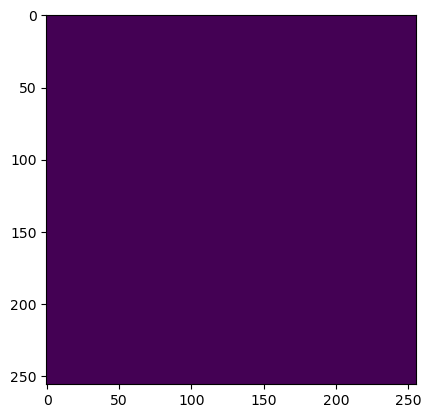

In [18]:
path = 'output_intermediate_model_3D/20231214_191521_S20_E64_L0.02197'
# shape of network in the Net_2D class needs to match the network in the file. See NODES = ...

threeD_nn = Net_3D()        
threeD_nn.load_state_dict( torch.load(path, map_location=device) )
threeD_nn = threeD_nn.to(device)
threeD_nn.eval()

# create 0 to 1 coordinate mesh
nx,ny = (256,256)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
z = 133 # [0:255]  choose slice to be dispalyed

coord = np.stack( np.meshgrid(x, y, z),axis=3)
#print(coord)
coord = torch.tensor( coord , dtype= torch.float32)

outputs = threeD_nn(coord)
outputs = np.reshape( outputs.detach().numpy(), (256,256))

plt.imshow(outputs)